In [80]:
import pod5
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 12
sys.path.insert(0, '/private/groups/brookslab/gabai/tools/NEMO/src/')
from predict import *
from plot import *
import importlib
from qc import *
from findWellPosGenes import *
importlib.reload(sys.modules['findWellPosGenes'])
from findWellPosGenes import *

In [8]:
from tqdm import tqdm

In [81]:
dt_outpath = '../data/'
fig_outpath = '../figures/'

In [69]:
# read well positioned genes
nuclei_rep1 = '../data/4_dorado_20190429_chrom_well_positioned_genes_cov22_cor0.5_var7100.bed'
nuclei_rep1_gene ={}
with open(nuclei_rep1) as infile:
    for line in infile:
        line=line.strip().split('\t')
        chr, start, end, genename, strand = line[0], line[1], line[2], line[3], line[5]
        nuclei_rep1_gene[(genename, strand)] = f'{chr}:{start}-{end}'
print(f'n genes: {len(nuclei_rep1_gene)}')

# read well positioned genes
nuclei_rep2 = '../data/4_dorado_20210615_chrom_well_positioned_genes_cov29_cor0.6_var9400.bed'
nuclei_rep2_gene ={}
with open(nuclei_rep2) as infile:
    for line in infile:
        line=line.strip().split('\t')
        chr, start, end, genename, strand = line[0], line[1], line[2], line[3], line[5]
        nuclei_rep2_gene[(genename, strand)] = f'{chr}:{start}-{end}'
print(f'n genes: {len(nuclei_rep2_gene)}')

# read well positioned genes
sphe = '../data/4_dorado_202205_sphe_chrom__well_positioned_genes_cov16_cor0.5_var5500.bed'
sphe_gene ={}
with open(sphe) as infile:
    for line in infile:
        line=line.strip().split('\t')
        chr, start, end, genename, strand = line[0], line[1], line[2], line[3], line[5]
        sphe_gene[(genename, strand)] = f'{chr}:{start}-{end}'
print(f'n genes: {len(sphe_gene)}')

# get shared well-positioned genes between 2 replicates
shared_nuclei_genes = list(set(nuclei_rep1_gene.keys()) & set(nuclei_rep2_gene.keys()))
print(len(shared_nuclei_genes))
# shared_nuclei_genes = list(set(nuclei_rep1_gene.keys()) & set(nuclei_rep2_gene.keys()) & set(sphe_gene.keys()))
# print(len(shared_nuclei_genes))
pregions ={}
for gene in nuclei_rep1_gene:
    if gene in shared_nuclei_genes:
        pregions[gene] = nuclei_rep1_gene[gene]

outf = open('6_38_well_positioned_genes.tsv', 'w')
for gene in pregions:
    outf.write(f'{gene}\n')

n genes: 380
n genes: 230
n genes: 57
38


In [71]:
# get single reads
predfile = '../data/prediction/240917_dorado_20210615_full.tsv'
strand = ''
outpath = dt_outpath
na_thred = 0.2
max_meth = 200
prefix = '6_all_38_gene_tss_modifications_rep2'
stranded = False
mtx, readnames, strands, genenames = [], [], [], []

for (genename, strand), pregion in pregions.items():
    
    print(f'start processing gene {genename}...')
    
    chrom = pregion.split(':')[0]
    locus = pregion.split(':')[1].split('-')
    pstart, pend = int(locus[0]), int(locus[1])
    with open(predfile, 'r') as infile:
        for line in tqdm(infile):
            thischrom = line.strip().split('\t')[1]
            if thischrom!= chrom:
                continue
            thisread = line.strip().split('\t')[0]
            thisstrand = 1 if line.strip().split('\t')[2] == '+' else -1
            if stranded:
                if thisstrand != strand:
                    continue
            start = int(line.strip().split('\t')[3])
            scores = line.strip().split('\t')[-1]
            scores = [float(i) for i in scores.split(',')]
            
            sortedread = [(start+i,j) for i, j in enumerate(scores)]
            if sortedread[0][0] > pend or sortedread[-1][0] < pstart: continue
            
            pos_scores = {i:-1 for i in range(pstart, pend+1)}
            poss = [i[0] for i in sortedread]
            
            left = bisect_left(poss, pstart)
            
            for i in range(left, len(sortedread)):
                pos, score = sortedread[i]
                if pos > pend:
                    break
                if pos not in pos_scores:
                    continue
                pos_scores[pos] = score
            
            thisscores = np.array([v for v in pos_scores.values()])
            # flip if the gene is on reverse strand
            thisscores = np.flip(thisscores) if strand == '-' else thisscores
            
            if np.sum(thisscores) != -1*len(thisscores):
                mtx.append(thisscores)
                readnames.append(thisread)
                strands.append(thisstrand)
                genenames.append(genename)
    print(f'finished processing gene {genename}...')

mtx = np.array(mtx, dtype = float)
mtx[mtx==-1] = np.nan
readnames = np.array(readnames, dtype = str)
strands = np.array(strands, dtype = int)
genenames = np.array(genenames, dtype = str)

print('number of reads before filtering:', len(readnames))
print(f'filtering reads with more than {na_thred} NA...')
little_na = np.invert(np.isnan(mtx).sum(axis = 1)>(mtx.shape[1]*na_thred))
mtx = mtx[little_na,:]
readnames = readnames[little_na]
strands = strands[little_na]
genenames = genenames[little_na]
print(f'number of reads kept: {len(readnames)}', )
print(f'filtering hyper-methylated reads...')
hyper_meth= np.invert(np.nanmean(mtx, axis = 1)>max_meth)
mtx = mtx[hyper_meth,:]
readnames = readnames[hyper_meth]
strands = strands[hyper_meth]
genenames = genenames[hyper_meth]
print(f'number of reads kept: {len(readnames)}')

outfile = outpath + prefix + '.mtx'
print('writing output to file: ', outfile)
mtxFh = open(outfile, 'w')
for line in mtx:
    mtxFh.write(','.join(np.array(line, dtype = str)) + '\n')
mtxFh.close()

outfile2 = outpath + prefix + '_rowannot.tsv'
outf = open(outfile2, 'w')
for i,j,k in zip(readnames, strands, genes):
    outf.write(f'{i}\t{j}\t{k}\n')
outf.close()

start processing gene zz-YIL161W...


1308037it [00:36, 36262.37it/s]


finished processing gene zz-YIL161W...
start processing gene SMC4...


1308037it [01:23, 15596.12it/s]


finished processing gene SMC4...
start processing gene GLE1...


1308037it [01:07, 19486.80it/s]


finished processing gene GLE1...
start processing gene FMP32...


1308037it [00:24, 52758.08it/s]


finished processing gene FMP32...
start processing gene TOR2...


1308037it [00:36, 35728.37it/s]


finished processing gene TOR2...
start processing gene ALR2...


1308037it [00:28, 46618.67it/s]


finished processing gene ALR2...
start processing gene ATG8...


1308037it [01:01, 21313.96it/s]


finished processing gene ATG8...
start processing gene VPS75...


1308037it [00:46, 28294.34it/s]


finished processing gene VPS75...
start processing gene SEC2...


1308037it [00:40, 32122.45it/s]


finished processing gene SEC2...
start processing gene TAF2...


1308037it [00:26, 49202.57it/s]


finished processing gene TAF2...
start processing gene SPT6...


1308037it [00:51, 25611.08it/s]


finished processing gene SPT6...
start processing gene FEX2...


1308037it [00:46, 27919.56it/s]


finished processing gene FEX2...
start processing gene zz-YOL029C...


1308037it [00:52, 24856.47it/s]


finished processing gene zz-YOL029C...
start processing gene FPR4...


1308037it [01:22, 15855.93it/s]


finished processing gene FPR4...
start processing gene SIR1...


1308037it [00:38, 34266.40it/s]


finished processing gene SIR1...
start processing gene BNA5...


1308037it [01:22, 15829.28it/s]


finished processing gene BNA5...
start processing gene NPR3...


1308037it [00:36, 35902.45it/s]


finished processing gene NPR3...
start processing gene MSH6...


1308037it [01:04, 20253.19it/s]


finished processing gene MSH6...
start processing gene RTF1...


1308037it [00:51, 25623.87it/s]


finished processing gene RTF1...
start processing gene VPS60...


1308037it [01:04, 20413.30it/s]


finished processing gene VPS60...
start processing gene YJU2...


1308037it [00:37, 34548.93it/s]


finished processing gene YJU2...
start processing gene MPA43...


1308037it [00:41, 31456.55it/s]


finished processing gene MPA43...
start processing gene HOM6...


1308037it [00:41, 31615.60it/s]


finished processing gene HOM6...
start processing gene ERV41...


1308037it [00:46, 28384.83it/s]


finished processing gene ERV41...
start processing gene PUF6...


1308037it [01:04, 20260.59it/s]


finished processing gene PUF6...
start processing gene CDC9...


1308037it [01:04, 20316.81it/s]


finished processing gene CDC9...
start processing gene YKT6...


1308037it [00:38, 33757.23it/s]


finished processing gene YKT6...
start processing gene YPF1...


1308037it [00:38, 34005.50it/s]


finished processing gene YPF1...
start processing gene SPR28...


1308037it [01:04, 20186.95it/s]


finished processing gene SPR28...
start processing gene REA1...


1308037it [01:22, 15823.85it/s]


finished processing gene REA1...
start processing gene IMG2...


1308037it [00:27, 47154.32it/s]


finished processing gene IMG2...
start processing gene FOB1...


1308037it [01:04, 20282.90it/s]


finished processing gene FOB1...
start processing gene FET5...


1308037it [00:26, 49265.53it/s]


finished processing gene FET5...
start processing gene RFA2...


1308037it [00:41, 31170.07it/s]


finished processing gene RFA2...
start processing gene IOC3...


1308037it [00:26, 49548.16it/s]


finished processing gene IOC3...
start processing gene RPS14B...


1308037it [00:41, 31849.42it/s]


finished processing gene RPS14B...
start processing gene SCH9...


1308037it [00:36, 35835.72it/s]


finished processing gene SCH9...
start processing gene PMT5...


1308037it [01:05, 19970.13it/s]


finished processing gene PMT5...
number of reads before filtering: 7494
filtering reads with more than 0.2 NA...
number of reads kept: 895
filtering hyper-methylated reads...
number of reads kept: 718
writing output to file:  ../data/6_all_33_gene_tss_modifications_rep2.mtx


In [82]:
if np.isnan(mtx).sum() != 0:
    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    new_mtx = imp.fit_transform(mtx)
else:
    new_mtx = mtx

df = pd.DataFrame(new_mtx)
df['gene'] = genenames  # Add the gene annotation to the matrix as a new column

# Group the matrix by gene
df['gene'] = pd.Categorical(df['gene'], categories=[i[0] for i in pregions][::-1], ordered=True)
df = df.sort_values('gene')

grouped_by_gene = df.groupby('gene', sort=False)

# Function for KMeans clustering for each gene
def kmeans_clustering_for_gene(gene_group, n_clusters=3):
    # Exclude the 'gene' column for clustering
    gene_reads = gene_group.drop(columns=['gene'])
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(gene_reads)
    
    # Add the cluster labels as a new column
    gene_group['cluster'] = clusters
    
    # Sort the rows by cluster labels
    sorted_gene_group = gene_group.sort_values(by='cluster')
    
    return sorted_gene_group.drop(columns=['cluster'])  # Drop the cluster column after sorting

# Function for hierarchical clustering for each gene
def hierarchical_clustering_for_gene(gene_group, method='ward', n_clusters=3):
    # Exclude the 'gene' column for clustering
    gene_reads = gene_group.drop(columns=['gene'])
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(gene_reads, method=method)
    
    # Get the flat clusters based on n_clusters
    clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    
    # Add the cluster labels as a new column
    gene_group['cluster'] = clusters
    
    # Sort the rows by cluster labels
    sorted_gene_group = gene_group.sort_values(by='cluster')
    
    return sorted_gene_group.drop(columns=['cluster'])  # Drop the cluster column after sorting

# 1. Apply clustering on each gene group and collect sorted groups
sorted_groups, clustered_genes = [], []

for gene_name, gene_group in grouped_by_gene:
    print(f"Clustering for {gene_name}")
    
    # Choose KMeans or Hierarchical clustering
    sorted_gene_group = kmeans_clustering_for_gene(gene_group, n_clusters=3)
    # Alternatively, use hierarchical clustering:
    # sorted_gene_group = hierarchical_clustering_for_gene(gene_group, n_clusters=3)

    # Append the sorted group to the list
    sorted_groups.append(sorted_gene_group.drop(columns=['gene']))  # Remove 'gene' column

    clustered_genes.extend([gene_name] * len(sorted_gene_group))
# 2. Concatenate all sorted groups back into one matrix
clustered_mtx = pd.concat(sorted_groups, axis=0).values  # Convert to numpy array

# The final output matrix
print("clustered matrix shape:", clustered_mtx.shape)

/data/tmp/ipykernel_2171032/1171544895.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_gene = df.groupby('gene', sort=False)
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/sit

Clustering for PMT5
Clustering for SCH9
Clustering for RPS14B
Clustering for IOC3


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for RFA2
Clustering for FET5


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for FOB1
Clustering for IMG2


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for REA1
Clustering for SPR28
Clustering for YPF1


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for YKT6
Clustering for CDC9


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for PUF6
Clustering for ERV41


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for HOM6
Clustering for MPA43


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for YJU2
Clustering for VPS60


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for RTF1
Clustering for MSH6
Clustering for NPR3


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for BNA5
Clustering for SIR1
Clustering for FPR4


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for zz-YOL029C
Clustering for FEX2
Clustering for SPT6


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for TAF2
Clustering for SEC2
Clustering for VPS75


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for ATG8
Clustering for ALR2
Clustering for TOR2


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for FMP32
Clustering for GLE1
Clustering for SMC4


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for zz-YIL161W
clustered matrix shape: (718, 1201)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 718/718 [15:31<00:00,  1.30s/it]


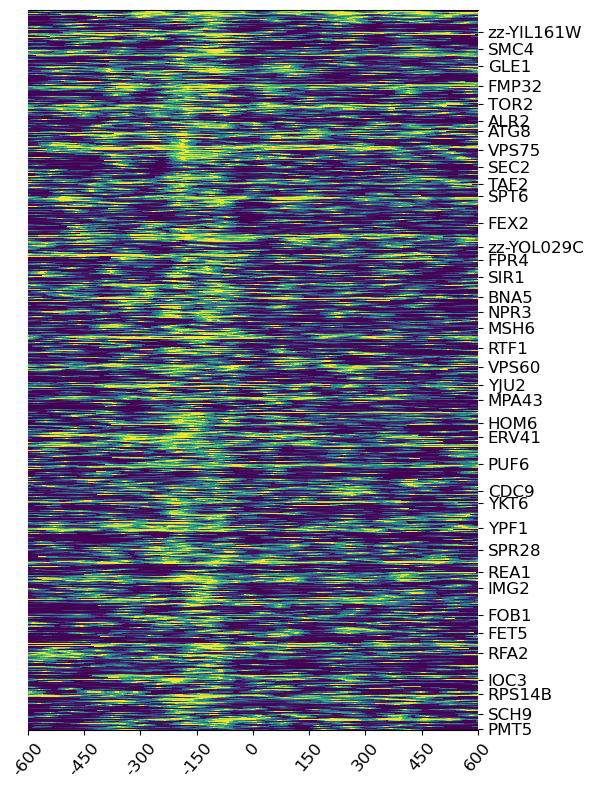

In [83]:
plt.figure(figsize=(5, 8))
pstart, pend = (-600, 600)
xticks_space = 150
ax = plt.axes((0.1, 0.1, 0.9, 0.9))
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_xticks(ticks= np.arange(pstart, pend+1, xticks_space))
ax.set_xticklabels(ax.get_xticks(), rotation = 50)
ax.set_xlim(pstart, pend)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
height = (1, 1)
bottom=0
tick_yaxis, label_yaxis = [],[]
total, count = np.zeros(clustered_mtx.shape[1], dtype = int), np.zeros(clustered_mtx.shape[1], dtype = int)
(R,G,B) = colorMap(palette = 'viridis', log_scale=False)
thisgene = ''

for i in tqdm(range(clustered_mtx.shape[0])):
    left = -600
    if thisgene != clustered_genes[i]:
        tick_yaxis.append(bottom)
        label_yaxis.append(clustered_genes[i])
        thisgene = clustered_genes[i]
    for j in range(clustered_mtx.shape[1]):
        score = clustered_mtx[i, j]
        if not np.isnan(score):
            count[j] += score
            total[j] += 1
        # no score at this position
        if np.isnan(score):
            col = 'lightgray'
        else:
            color = int((score/256)*100)
            col=(R[color],G[color],B[color])
        thisalpha = 1
        rectangle = mplpatches.Rectangle([left, bottom-(height[0]*0.5)], 1, height[0], 
                                         facecolor = col, edgecolor = 'silver', linewidth = 0, alpha=thisalpha)
        ax.add_patch(rectangle)
        left += 1
    bottom +=height[0]

aggregate = np.divide(np.divide(count, total), 256)
if np.max(total) < 1:
    aggregate = np.zeros(clustered_mtx.shape[1])
ax.bar(np.arange(pstart, pend+1), aggregate, bottom=bottom, width = 1.0, color = 'tab:blue')
bottom+=1
ax.set_yticks(ticks = tick_yaxis, labels = label_yaxis)
ax.set_ylim(0-0.5*height[0], bottom)

plt.savefig(fig_outpath+ f'6_top_well_positioned_genes_clustered_within_gene_rep2.pdf', bbox_inches='tight')

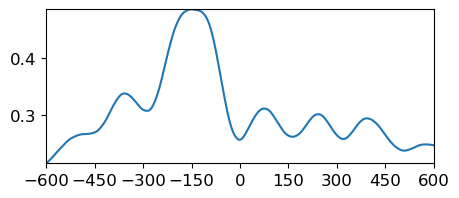

In [84]:
from scipy.signal import savgol_filter
smoothed_agg = savgol_filter(aggregate, 150, 3, mode="nearest")
plt.figure(figsize=(5, 2))
plt.plot(np.arange(pstart, pend+1), smoothed_agg)
plt.xticks(ticks= np.arange(pstart, pend+1, xticks_space))
plt.ylim(min(smoothed_agg), max(smoothed_agg))
plt.xlim(-600, 600)
plt.savefig(fig_outpath+ f'6_top_aggregated_panel_rep2.pdf', bbox_inches='tight')